In [1]:
import pandas as pd

def train_test_split():
    def remove_pairs(df_test1, df_train1):
        def filter(df_test1, df_train1):
            merged = df_test1.merge(df_train1, on=['NmId1', 'NmId2'], how='left', indicator=True)
            df_result = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])
            return df_result
            
        df_result = filter(df_test1, df_train1)
        
        df_result_swapped = df_result.rename(columns={'NmId1': 'NmId2', 'NmId2': 'NmId1'})
        df_result_filtered = filter(df_result_swapped, df_train1)
        
        df_result_final = df_result_filtered.rename(columns={'NmId2': 'NmId1', 'NmId1': 'NmId2'})
        
        bad_indices = df_test1[~df_test1.index.isin(df_result_final.index)].index
        good_indices = df_result_final.index
        return bad_indices, good_indices
    
    clms = ['NmId1', 'NmId2', 'subjectid', 'subjectname', 'Target',
           'HardNegative']
    
    pth = "/home/sondors.igor/documents/ColBERT/DATASET/markup_recommend_preprocessing_no_emb"
    df_distances = pd.read_parquet(pth)[clms]
    print(len(df_distances))
    
    pth = "/home/sondors.igor/documents/ColBERT/DATASET/markup_recommend_test_df_2mln_no_emb"
    df_test = pd.read_parquet(pth)[clms]
    print(len(df_test))
    
    bad_indices, good_indices = remove_pairs(df_distances, df_test)
    df_train = df_distances.loc[good_indices].reset_index(drop=True)
    print(len(df_train))
    df_train.to_parquet("pairs_train.parquet")
    df_test.to_parquet("pairs_test.parquet")
    df_train.head()

df_train = pd.read_parquet("pairs_train.parquet")
df_test = pd.read_parquet("pairs_test.parquet")
print(len(df_train), len(df_test), int(len(df_train) / len(df_test)))


11975375 2562446 4


In [3]:
len(df_test)/len(df_train)

0.21397626379132179

In [4]:
df_train

,NmId1,NmId2,subjectid,subjectname,Target,HardNegative
0,153108241,509476,236,Фигурки,0,0.0
1,15233171,509476,236,Фигурки,0,0.0
2,153475651,509476,236,Фигурки,1,NaN
3,159668428,890500,268,Мягкие игрушки,0,1.0
4,98789352,890500,268,Мягкие игрушки,0,0.0
...,...,...,...,...,...,...
11975370,205429142,166731303,350,Косметические карандаши,0,1.0
11975371,213777765,166731303,350,Косметические карандаши,0,1.0
11975372,174061919,166731303,350,Косметические карандаши,0,0.0
11975373,205429178,166731303,350,Косметические карандаши,0,1.0


In [5]:
df_train.columns

Index(['NmId1', 'NmId2', 'subjectid', 'subjectname', 'Target', 'HardNegative'], dtype='object')

In [ ]:
# Дан pd df с колонками 'NmId1', 'NmId2', 'Target' . 'Target' может иметь значения 0 или 1, 0. 
# Для имеющихся данных нужно составить триплеты NmId, NmId_target_0, NmId_target_1

In [17]:
# Разделяем на два DataFrame в зависимости от значения Target
df_target_0 = df_train[df_train['Target'] == 0].rename(columns={'NmId2': 'NmId_target_0'})
df_target_1 = df_train[df_train['Target'] == 1].rename(columns={'NmId2': 'NmId_target_1'})

# Мержим два DataFrame по NmId1
result = pd.merge(df_target_0[['NmId1', 'NmId_target_0', 'HardNegative']],
                  df_target_1[['NmId1', 'NmId_target_1']],
                  on='NmId1').rename(columns={'NmId1': 'NmId'})

# Выводим результат
result

,NmId,NmId_target_0,HardNegative,NmId_target_1
0,153108241,509476,0.0,15233171
1,98789352,890500,0.0,36094535
2,138656537,890500,0.0,98792000
3,97092317,890500,0.0,10785185
4,97092317,890500,0.0,73710189
...,...,...,...,...
14850519,174061919,166731303,0.0,144118085
14850520,174061919,166731303,0.0,62402761
14850521,174061919,166731303,0.0,41142227
14850522,186255320,166731303,0.0,104573855


<Axes: >

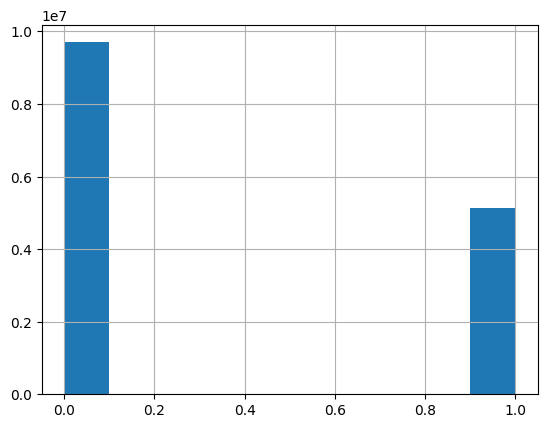

In [18]:
result.HardNegative.hist()

In [2]:
pth = "/home/sondors.igor/documents/ColBERT/DATASET/unique_NmId.parquet"
df_unique = pd.read_parquet(pth)
print(len(df_unique))
df_unique.head()

5057759


,NmId,subjectid,subjectname,brandname_normalized_NmId,title_NmId
0,15233171,236,Фигурки,blue sky,"Фигурка на полку ""Котенок Клайд"""
1,153108241,236,Фигурки,дом фарфора,"Фигурка на полку ""Котенок Клайд"""
2,153475651,236,Фигурки,pavone,"Фигурка на полку ""Котенок Клайд"""
3,138739467,268,Мягкие игрушки,maxitoys,Мягкая игрушка мишка / плюшевый медведь медвеж...
4,98795049,268,Мягкие игрушки,maxitoys,Мягкая игрушка медведь / Плюшевый мишка


In [74]:
pth = "/home/sondors.igor/documents/ColBERT/DATASET/unique_charcs.parquet"
df_unique_charcs = pd.read_parquet(pth)
print(len(df_unique_charcs))
df_unique_charcs.head()

5057759


,NmId,characteristics_NmId
0,15233171,Вес товара с упаковкой (г): 300.0 г; Высота пр...
1,153108241,Вес товара с упаковкой (г): 300.0 г; Высота пр...
2,153475651,Вес товара с упаковкой (г): 300.0 г; Высота пр...
3,138739467,Вес товара с упаковкой (г): 165.0 г; Вид мягко...
4,98795049,Вес товара с упаковкой (г): 150.0 г; Вид мягко...


In [91]:
y = "Вес товара без упаковки (г): 4.5 г; Вес товара с упаковкой (г): 4.5 г; Возрастные ограничения: от 14; Высота упаковки: 10.0 см; Действие: блеск губ, макияж губ, окрашивание губ; Длина упаковки: 2.0 см; Комплектация: Блеск для губ - 1шт; Назначение косметического средства: для макияжа губ, для губ; Назначение подарка: Маме Бабушке Жене Подруге Дочке; Маме Бабушке Жене; Объем товара: 4.5 мл; Особенность оттенка: глянцевый блеск; Повод: на каждый день повседневная; Прямые поставки от производителя: да; Раздел меню: Красота / для макияжа; Состав: косметическая основа; Срок годности: 36 мес; Страна производства: Беларусь; Упаковка: термо пленка; Форма упаковки: без давления; Ширина упаковки: 2.0 см"
df_unique_charcs[df_unique_charcs.characteristics_NmId == y]

,NmId,characteristics_NmId
241,86861964,Вес товара без упаковки (г): 4.5 г; Вес товара...
928664,86861967,Вес товара без упаковки (г): 4.5 г; Вес товара...


In [97]:
y[50:]

'паковкой (г): 4.5 г; Возрастные ограничения: от 14; Высота упаковки: 10.0 см; Действие: блеск губ, макияж губ, окрашивание губ; Длина упаковки: 2.0 см; Комплектация: Блеск для губ - 1шт; Назначение косметического средства: для макияжа губ, для губ; Назначение подарка: Маме Бабушке Жене Подруге Дочке; Маме Бабушке Жене; Объем товара: 4.5 мл; Особенность оттенка: глянцевый блеск; Повод: на каждый день повседневная; Прямые поставки от производителя: да; Раздел меню: Красота / для макияжа; Состав: косметическая основа; Срок годности: 36 мес; Страна производства: Беларусь; Упаковка: термо пленка; Форма упаковки: без давления; Ширина упаковки: 2.0 см'

In [99]:
charc_dict

{'Вес товара без упаковки (г)': '4.5 г',
 'Вес товара с упаковкой (г)': '4.5 г',
 'Возрастные ограничения': 'от 14',
 'Высота упаковки': '10.0 см',
 'Действие': 'блеск губ, макияж губ, окрашивание губ',
 'Длина упаковки': '2.0 см',
 'Комплектация': 'Блеск для губ - 1шт',
 'Назначение косметического средства': 'для макияжа губ, для губ',
 'Назначение подарка': 'Маме Бабушке Жене Подруге Дочке',
 'Маме Бабушке Жене': '',
 'Объем товара': '4.5 мл',
 'Особенность оттенка': 'глянцевый блеск',
 'Повод': 'на каждый день повседневная',
 'Прямые поставки от производителя': 'да',
 'Раздел меню': 'Красота / для макияжа',
 'Состав': 'косметическая основа',
 'Срок годности': '36 мес',
 'Страна производства': 'Беларусь',
 'Упаковка': 'термо пленка',
 'Форма упаковки': 'без давления',
 'Ширина упаковки': '2.0 см'}

In [101]:
def parse_attributes(raw_string):
    x = [ 'Комплектация',
     'Цвет',
     'Высота предмета',
     'Ширина предмета',
     'Состав',
     'Материал изделия',
     'Упаковка',
     'Количество предметов в упаковке',
     'Вес товара без упаковки (г)',
     'Модель',
     'Рисунок',
     'Пол',
     'Назначение косметического средства',
     'Объем товара',
     'Наименование книги',
     'Вес без упаковки (кг)',
     'Вид животного',
     'Возрастная группа',
     'Материал корпуса',
     'Длина предмета',
     'Возраст животного',
     'Размер животного',
     'Основной вкус корма',
     'Особенности модели',
     'Назначение корма',
     'Материал игрушки',
     'Вид вкуса корма',
     'Класс корма',
     'Мощность устройства',
     'Сюжет',
     'Оптическая сила',
     'Тип кожи',
     'Размер картины',
     'Радиус кривизны',
     'Тип цоколя',
     'Вид семян']
    
    charc_dict = {}
    for part in raw_string.split(';'):
        split = part.split(':')
        if len(split) == 2:
            charc_dict[split[0].strip()] = split[1].strip()
        else:
            charc_dict[split[0].strip()] = ''
            
    result_string = '' 
    for charc in charc_dict.keys():
        if charc in x:
            result_string += f"{charc}: {charc_dict[charc]}; "
    return result_string[:-2]
    

df_unique_charcs['charcs'] = df_unique_charcs['characteristics_NmId'].apply(parse_attributes)
df_unique_charcs

,NmId,characteristics_NmId,charcs
0,15233171,Вес товара с упаковкой (г): 300.0 г; Высота пр...,Высота предмета: 9.0 см; Комплектация: фигурка...
1,153108241,Вес товара с упаковкой (г): 300.0 г; Высота пр...,Высота предмета: 9.0 см; Комплектация: фигурка...
2,153475651,Вес товара с упаковкой (г): 300.0 г; Высота пр...,Высота предмета: 9.0 см; Комплектация: фигурка...
3,138739467,Вес товара с упаковкой (г): 165.0 г; Вид мягко...,Высота предмета: 23.0 см; Комплектация: игрушк...
4,98795049,Вес товара с упаковкой (г): 150.0 г; Вид мягко...,Высота предмета: 19.0 см; Комплектация: игрушк...
...,...,...,...
5057754,220708403,Вес товара без упаковки (г): 430.0 г; Вес това...,Вес товара без упаковки (г): 430.0 г; Комплект...
5057755,220761147,ISBN: 978-5-98-862544-5; Автор: Сарсенова Кари...,Вес товара без упаковки (г): 219.0 г
5057756,220834324,Артикул производителя: FD3084; Вес товара без ...,Вес товара без упаковки (г): 210.0 г; Комплект...
5057757,221396547,ISBN: 978-5-04-191292-5; Автор: Дмитрий Ивченк...,Высота предмета: 23.5 см; Наименование книги: ...


In [102]:
df_unique_charcs[df_unique_charcs.NmId == 138656537].charcs.values[0]

'Высота предмета: 25.0 см; Комплектация: игрушка; Материал игрушки: искусственный мех, текстиль, пластик; Цвет: белый; Ширина предмета: 19.0 см'

In [21]:
df_unique['brand_title']=df_unique.apply(lambda x: f'{x.brandname_normalized_NmId} {x.title_NmId}',axis=1)

In [25]:
df_unique

,NmId,subjectid,subjectname,brandname_normalized_NmId,title_NmId,brand_title
0,15233171,236,Фигурки,blue sky,"Фигурка на полку ""Котенок Клайд""","blue sky Фигурка на полку ""Котенок Клайд"""
1,153108241,236,Фигурки,дом фарфора,"Фигурка на полку ""Котенок Клайд""","дом фарфора Фигурка на полку ""Котенок Клайд"""
2,153475651,236,Фигурки,pavone,"Фигурка на полку ""Котенок Клайд""","pavone Фигурка на полку ""Котенок Клайд"""
3,138739467,268,Мягкие игрушки,maxitoys,Мягкая игрушка мишка / плюшевый медведь медвеж...,maxitoys Мягкая игрушка мишка / плюшевый медве...
4,98795049,268,Мягкие игрушки,maxitoys,Мягкая игрушка медведь / Плюшевый мишка,maxitoys Мягкая игрушка медведь / Плюшевый мишка
...,...,...,...,...,...,...
5057754,220708403,385,Дезодоранты,indoherbs,"Минеральный дезодорант с алоэ вера, 60 г. * 5 шт.","indoherbs Минеральный дезодорант с алоэ вера, ..."
5057755,220761147,381,Книги,грифон,Легенда Евразии: Эрик Окинарена: Квантовая мед...,грифон Легенда Евразии: Эрик Окинарена: Кванто...
5057756,220834324,5886,Пыльники автомобильные,sufix,Пыльник амортизатора передний в сборе с отбойн...,sufix Пыльник амортизатора передний в сборе с ...
5057757,221396547,381,Книги,эксмо,Хирургия ранений груди,эксмо Хирургия ранений груди


In [56]:
NmId_brand_title = dict(zip(list(df_unique.NmId), list(df_unique.brand_title)))

In [103]:
NmId_charcs = dict(zip(list(df_unique_charcs.NmId), list(df_unique_charcs.charcs)))

In [57]:
NmId_brand_title[15233171]

'blue sky Фигурка на полку "Котенок Клайд"'

In [54]:
result

,NmId,NmId_target_0,HardNegative,NmId_target_1
0,153108241,509476,0.0,15233171
1,98789352,890500,0.0,36094535
2,138656537,890500,0.0,98792000
3,97092317,890500,0.0,10785185
4,97092317,890500,0.0,73710189
...,...,...,...,...
14850519,174061919,166731303,0.0,144118085
14850520,174061919,166731303,0.0,62402761
14850521,174061919,166731303,0.0,41142227
14850522,186255320,166731303,0.0,104573855


In [104]:
def fn(x):
    return f"{NmId_brand_title[x]} {NmId_charcs[x]}"

result['name'] = result['NmId'].apply(fn)
result['false_match'] = result['NmId_target_0'].apply(fn)
result['true_match'] = result['NmId_target_1'].apply(fn)
result

,NmId,NmId_target_0,HardNegative,NmId_target_1,name,false_match,true_match
0,153108241,509476,0.0,15233171,"дом фарфора Фигурка на полку ""Котенок Клайд"" В...",blue sky Фигурка ''Котенок Клайд'' Материал из...,"blue sky Фигурка на полку ""Котенок Клайд"" Высо..."
1,98789352,890500,0.0,36094535,maxitoys Мягкая игрушка зайка / Плюшевый зайчи...,maxitoys Мягкая игрушка плюшевый мишка Высота ...,maxitoys Мягкая игрушка плюшевый зайка Высота ...
2,138656537,890500,0.0,98792000,maxitoys luxury Мягкая игрушка мишка / плюшевы...,maxitoys Мягкая игрушка плюшевый мишка Высота ...,maxitoys Мягкая игрушка медведь / Плюшевый миш...
3,97092317,890500,0.0,10785185,"fluffy heart Мягкая игрушка плюшевая панда, 35...",maxitoys Мягкая игрушка плюшевый мишка Высота ...,"fluffy heart Мягкая игрушка плюшевая панда, 35..."
4,97092317,890500,0.0,73710189,"fluffy heart Мягкая игрушка плюшевая панда, 35...",maxitoys Мягкая игрушка плюшевый мишка Высота ...,"fluffy heart Мягкая игрушка Панда, 35 см Высот..."
...,...,...,...,...,...,...,...
14850519,174061919,166731303,0.0,144118085,eveline Автоматический карандаш с растушевкой ...,belor design Механический карандаш для глаз. Т...,eveline Рив Гош│ Косметический карандаш для гл...
14850520,174061919,166731303,0.0,62402761,eveline Автоматический карандаш с растушевкой ...,belor design Механический карандаш для глаз. Т...,eveline Карандаш для глаз автоматический Вес т...
14850521,174061919,166731303,0.0,41142227,eveline Автоматический карандаш с растушевкой ...,belor design Механический карандаш для глаз. Т...,eveline Автоматический карандаш с растушевкой ...
14850522,186255320,166731303,0.0,104573855,stellary Автоматический карандаш для глаз / Au...,belor design Механический карандаш для глаз. Т...,stellary Карандаш для глаз Stellary 04


In [106]:
result.to_parquet("train_triplets.parquet")

In [108]:
def fn(x):
    return f"{NmId_brand_title[x]} {NmId_charcs[x]}"

df_test['name1'] = df_test['NmId1'].apply(fn)
df_test['name2'] = df_test['NmId2'].apply(fn)

df_test.to_parquet("pairs_test_names.parquet")

In [107]:
df_test

,NmId1,NmId2,subjectid,subjectname,Target,HardNegative
0,7321082,4132696,381,Книги,0,1.0
1,8811543,929620,98,Сабо,0,1.0
2,10525931,10525930,4472,Насосы поверхностные,0,0.0
3,10609515,10609382,2915,Семена,0,0.0
4,11755361,10306338,731,Игрушки для животных,0,1.0
...,...,...,...,...,...,...
2562441,222570833,149996012,2501,Воблеры,0,1.0
2562442,222582652,210034640,515,Смартфоны,0,0.0
2562443,223135523,210133897,357,Кремы,0,0.0
2562444,224321362,212964087,5806,Комплекты клавиатур и мышей,0,0.0


In [73]:
index_ = 2

print('name:       ', result.iloc[index_]['name'])
print("true_match: ", result.iloc[index_].true_match)
print("false_match:", result.iloc[index_].false_match)

name:        maxitoys luxury Мягкая игрушка мишка / плюшевый медведь
true_match:  maxitoys Мягкая игрушка медведь / Плюшевый мишка
false_match: maxitoys Мягкая игрушка плюшевый мишка


In [105]:
index_ = 2

print('name:       ', result.iloc[index_]['name'])
print("true_match: ", result.iloc[index_].true_match)
print("false_match:", result.iloc[index_].false_match)

name:        maxitoys luxury Мягкая игрушка мишка / плюшевый медведь Высота предмета: 25.0 см; Комплектация: игрушка; Материал игрушки: искусственный мех, текстиль, пластик; Цвет: белый; Ширина предмета: 19.0 см
true_match:  maxitoys Мягкая игрушка медведь / Плюшевый мишка Высота предмета: 25.0 см; Комплектация: игрушка; Материал игрушки: мех искусственный, трикотажное волокно, фурнитура из пластмассы; Цвет: белый, красный; Ширина предмета: 19.0 см
false_match: maxitoys Мягкая игрушка плюшевый мишка Высота предмета: 30.0 см; Комплектация: мягкая игрушка; Материал игрушки: искусственный мех, текстиль, пластик; Цвет: слоновая кость; Ширина предмета: 24.0 см


In [66]:
result.iloc[index_]['name']

'maxitoys luxury Мягкая игрушка мишка / плюшевый медведь'

In [55]:
# for index, row in result[2000000:2000010].iterrows():
#     NmId_ = int(row['NmId'])
#     NmId_target_0 = int(row['NmId_target_0'])	
#     HardNegative = row['HardNegative']	
#     NmId_target_1 = int(row['NmId_target_1'])

#     print(f"match:\n{df_unique[df_unique.NmId == NmId_].brand_title.values[0]} --> {df_unique[df_unique.NmId == NmId_target_1].brand_title.values[0]}")
#     print(f"false_match:\n{df_unique[df_unique.NmId == NmId_].brand_title.values[0]} --> {df_unique[df_unique.NmId == NmId_target_0].brand_title.values[0]}\n\n")
